In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow as tf
import seaborn as sns

In [2]:
def load_dataset(directory, image_size, batch_size):
    datagen = ImageDataGenerator(
        rescale=1.0/255,
        validation_split=0.2 
    )
    
    # Load data pelatihan
    train_data = datagen.flow_from_directory(
        directory,
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='training',
        classes=['concord', 'merah', 'thomspon'] 
    )
    
    # Load data validasi
    val_data = datagen.flow_from_directory(
        directory,
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='validation',
        classes=['concord', 'merah', 'thompson']
    )
    
    return train_data, val_data


In [3]:
def visualize_sample_images(data_generator, num_images=9):
    class_indices = data_generator.class_indices
    index_to_class = {v: k for k, v in class_indices.items()} 
    
    images, labels = next(data_generator)
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        label_index = np.argmax(labels[i])
        plt.title(f"Label: {index_to_class[label_index]}") 
        plt.axis('off')
    plt.tight_layout()
    plt.show()


In [4]:
def prepare_data(train_dir, image_size, batch_size):
    train_data, val_data = load_dataset(train_dir, image_size, batch_size)
    print(f"Jumlah data training: {train_data.samples}")
    print(f"Jumlah data validasi: {val_data.samples}")
    return train_data, val_data

In [5]:
from tensorflow.keras.applications import VGG16

def build_model(input_shape, num_classes):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    for layer in base_model.layers:
        layer.trainable = False

    model = Sequential([
        base_model,
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [6]:
def plot_training_metrics(history):
    # Plot akurasi
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [7]:
def train_model(model, train_data, val_data, epochs=20, save_path='hasilvgg.h5'):
    early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, verbose=1)

    history = model.fit(
        train_data,
        validation_data=val_data,
        epochs=epochs,
        callbacks=[early_stopping],
        verbose=1
    )

    model.save(save_path)
    print(f"Model saved to {save_path} in .h5 format.")

    plot_training_metrics(history)
    
    return history


In [8]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def predict_single_image(model, image_path, image_size, class_names):
    image = load_img(image_path, target_size=image_size)
    image_array = img_to_array(image) 
    image_array = np.expand_dims(image_array, axis=0) 
    image_array = image_array / 255.0


    predictions = model.predict(image_array)
    predicted_class_index = np.argmax(predictions[0])
    predicted_class_name = class_names[predicted_class_index]

    plt.figure(figsize=(5, 5))
    plt.imshow(image)
    plt.title(f"Predicted: {predicted_class_name}\nConfidence: {predictions[0][predicted_class_index]:.2f}")
    plt.axis('off')
    plt.show()

    return predicted_class_name

In [9]:
def visualize_predictions(model, data_generator, class_names, num_images=8):
    images, labels = next(data_generator)
    predictions = model.predict(images) 
    
    plt.figure(figsize=(15, 10))
    for i in range(num_images):
        plt.subplot(2, 4, i + 1) 
        plt.imshow(images[i])
        true_label_index = np.argmax(labels[i]) 
        predicted_label_index = np.argmax(predictions[i])
        confidence = predictions[i][predicted_label_index]
        
        true_label = class_names[true_label_index]
        predicted_label = class_names[predicted_label_index]
        plt.title(
            f"True: {true_label}\nPred: {predicted_label}\nConf: {confidence:.2f}",
            color="green" if true_label == predicted_label else "red"
        )
        plt.axis('off')
    plt.tight_layout()
    plt.show()


In [10]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def evaluate_model(model_path, val_data):
    model = tf.keras.models.load_model(model_path)
    val_loss, val_accuracy = model.evaluate(val_data)
    print(f"Validation Accuracy: {val_accuracy*100:.2f}%")
    print(f"Validation Loss: {val_loss:.4f}")
    
    y_true = val_data.classes
    y_pred = np.argmax(model.predict(val_data), axis=1)
    
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['concord', 'merah', 'thompson'], yticklabels=['concord', 'merah', 'thompson'])
    plt.title("Confusion Matrix")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()


In [11]:
dataset_path = r"D:\Semester 5\Pembelajaran Mesin\UAS\train_data"
image_size = (224, 224)
batch_size = 32

In [12]:
train_data, val_data = prepare_data(dataset_path, image_size, batch_size)

Found 160 images belonging to 3 classes.
Found 62 images belonging to 3 classes.
Jumlah data training: 160
Jumlah data validasi: 62


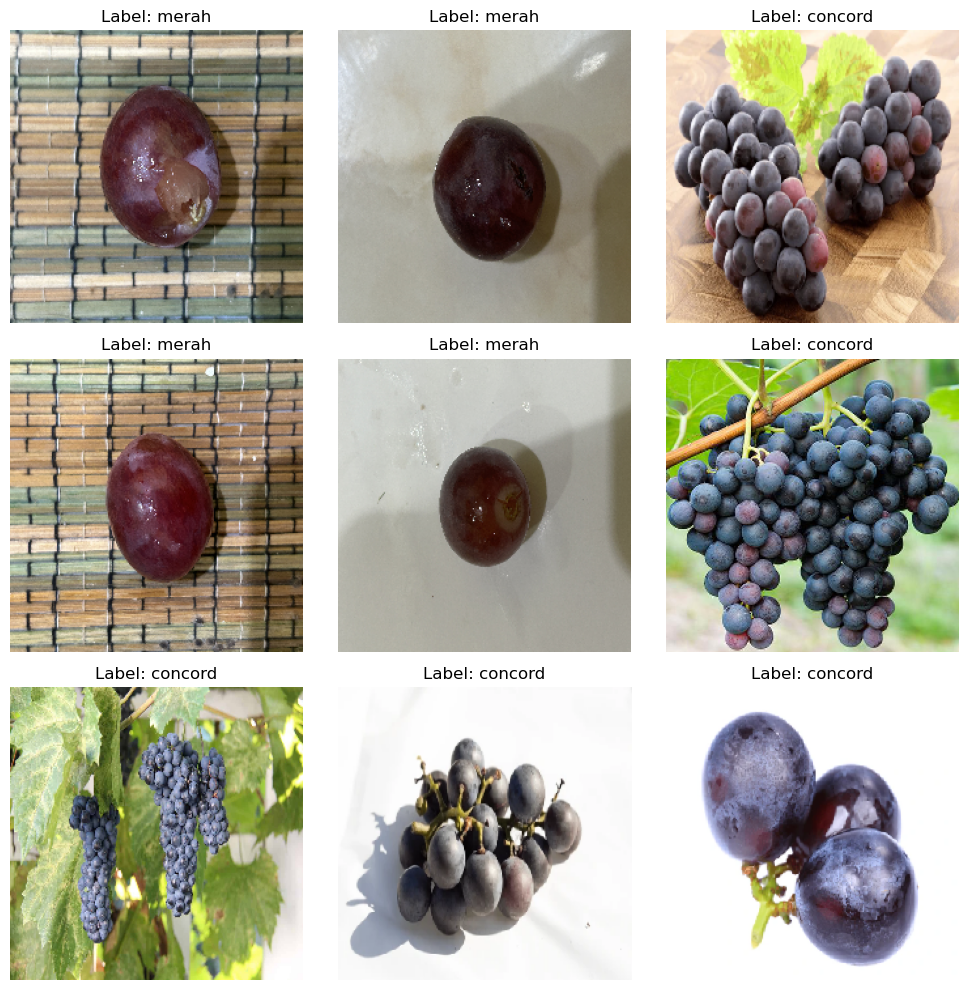

In [13]:
visualize_sample_images(train_data, num_images=9)

In [14]:
input_shape = (224, 224, 3)
num_classes = train_data.num_classes
model = build_model(input_shape, num_classes)

In [15]:
history = train_model(model, train_data, val_data, epochs=20, save_path='hasilvgg.h5')

ValueError: The filepath provided must end in `.keras` (Keras model format). Received: filepath=hasilvgg.h5

In [250]:
# evaluate_model('hasilvgg.keras', val_data)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


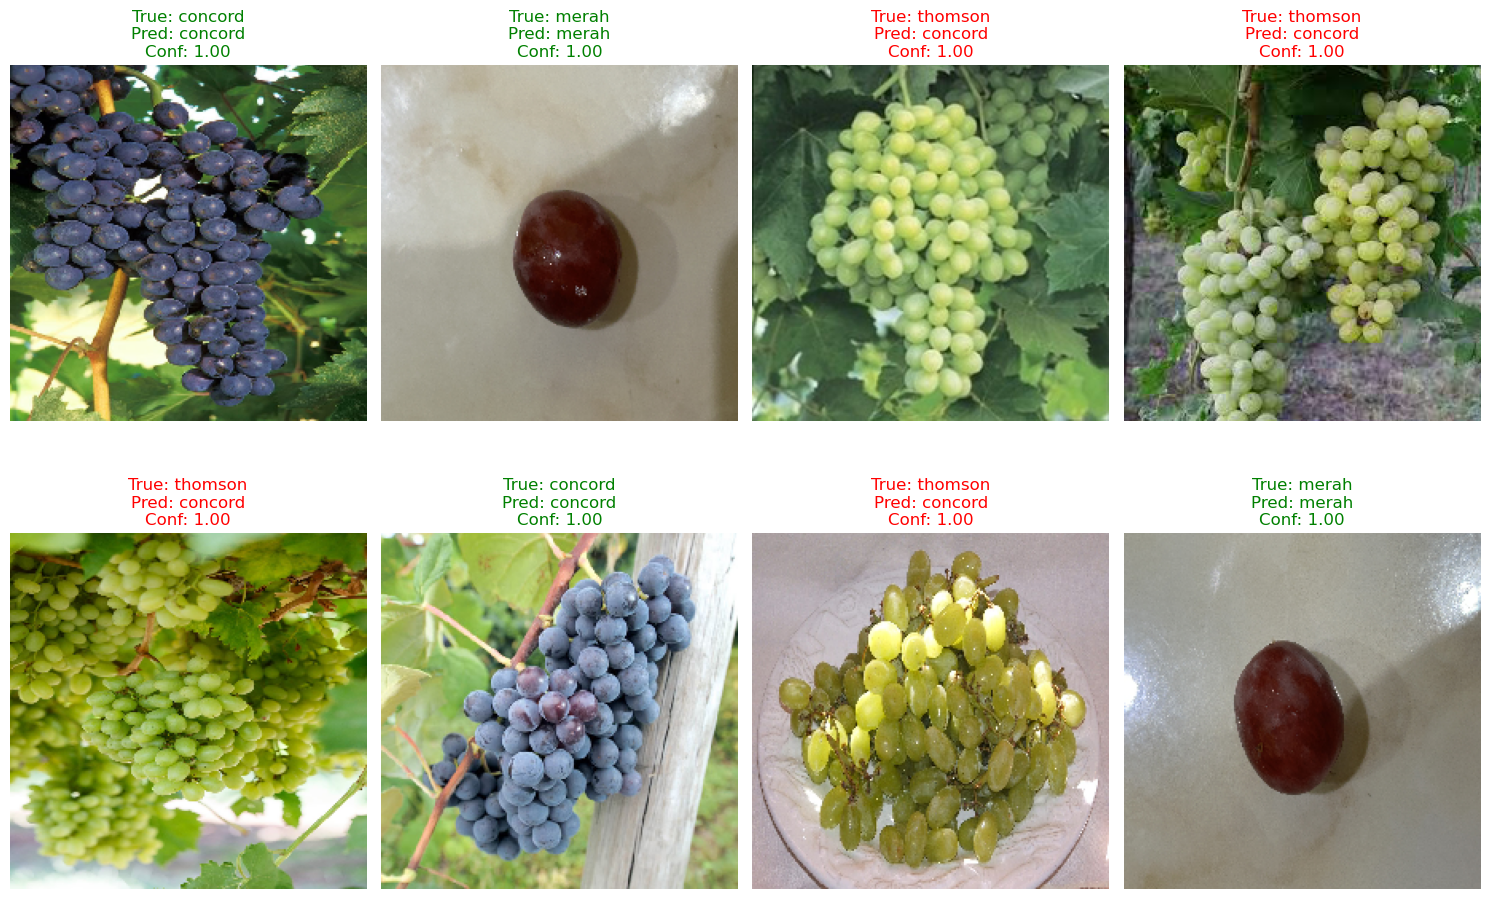

In [251]:
visualize_predictions(model, val_data, class_names, num_images=8)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step


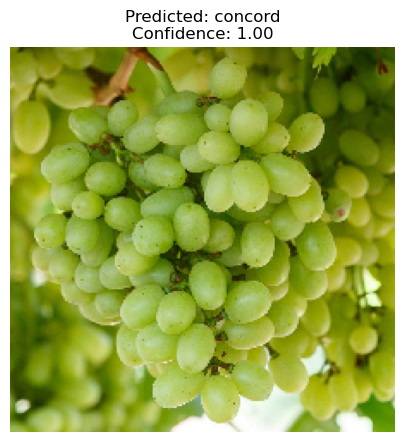

'concord'

In [252]:
# Path ke gambar
image_path = r"D:\Semester 5\Pembelajaran Mesin\UAS\train_data\Thompson\Thompson_Grape_Original_Data033.jpg"

# Nama kelas
class_names = ['concord', 'merah', 'thomson']

# Ukuran gambar (harus sesuai dengan input model)
image_size = (224, 224)

# Prediksi gambar
predict_single_image(model, image_path, image_size, class_names)